### Packages

In [1]:
import os
import shutil
import datetime
import xmltodict
import xml.etree.ElementTree as et
import json
import missingno as msno
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 200)

### Set Paths and Create 7z (and zip)

In [2]:
root_folder = "/Users/Alper/Documents/Music Production/Ableton Projects/ProcessingTest Project"

processing_folder = "/Users/Alper/Documents/Processing/Sense"
file = "ProcessingTest"
file_als = file+".als"
file_7z  = file+".7z"
file_zip = file+".zip"
file_xml = file+".xml"

shutil.copy(os.path.join(root_folder,file_als),
            os.path.join(root_folder,file_7z))

shutil.copy(os.path.join(root_folder,file_als),
            os.path.join(root_folder,file_zip))

print(os.path.join(root_folder,file))

/Users/Alper/Documents/Music Production/Ableton Projects/ProcessingTest Project/ProcessingTest


# TODO Before Running Below Cells
- go to 'root_folder' and extract the created .7z file with any unarchiver app so we can read the extracted xml file in the below cells

### Helper Functions

In [3]:
def calculator(bpm=120,fps=30):    
    
    meta = {}
    print(bpm,'beats per minute')

    bps = bpm/60
    print(bps,'beats per second')
    
    spb = 60/bpm
    print(spb,'seconds per beat')
    
    spbr = spb * 4
    print(spbr,'seconds per bar')
    
    fpb = fps*spb
    print(fpb,'frames per beat')
    
    fpbr = fpb*4
    print(fpbr,'frames per bar')
    
    freq = 1/fps
    print(fpbr,'frequency')

 

    meta['bpm'] = bpm
    meta['fps'] = fps
    meta['bps'] = bps
    meta['spb'] = spb
    meta['spbr'] = spbr
    meta['fpb'] = fpb
    meta['fpbr'] = fpbr
    meta['freq'] = freq

    return meta

def plot_df(df, which_plot = '2'):
    # plot 1
    if which_plot == '1':
        df.plot(figsize=(30,6))
    
    # plot 2
    elif which_plot == '2':


        axes = df.plot(subplots=True, layout=(6, 1), figsize=(15, 10))

        axes = axes.flat  # .ravel() and .flatten() also work

        fig = axes[0].get_figure()

        for ax in axes:

            ax.legend(loc='upper right', 
                      # bbox_to_anchor=(0.5, 1.10), 
                      frameon=True)

        fig.suptitle('Automations', fontsize=22, y=0.95)
        plt.show()
        
    elif which_plot == '12':
        plot_df(df,'1')
        plot_df(df,'2')

### .als XML to .als Dict

In [4]:
xml_doc_path = os.path.join(root_folder,file)
xml_tree = et.parse(xml_doc_path)
root = xml_tree.getroot()
to_string  = et.tostring(root, encoding='UTF-8', method='xml')
xml_to_dict = xmltodict.parse(to_string)

miditracks = xml_to_dict['Ableton']['LiveSet']['Tracks']['MidiTrack']

### Check Content

In [7]:
miditracks[0].keys()
# miditracks[0]['AutomationEnvelopes']['Envelopes']['AutomationEnvelope'][1]['Automation'] # Automations are here
# miditracks[0]['DeviceChain'].keys() # Macro IDs

odict_keys(['@Id', 'LomId', 'LomIdView', 'IsContentSelectedInDocument', 'PreferredContentViewMode', 'TrackDelay', 'Name', 'Color', 'AutomationEnvelopes', 'TrackGroupId', 'TrackUnfolded', 'DevicesListWrapper', 'ClipSlotsListWrapper', 'ViewData', 'TakeLanes', 'LinkedTrackGroupId', 'SavedPlayingSlot', 'SavedPlayingOffset', 'Freeze', 'VelocityDetail', 'NeedArrangerRefreeze', 'PostProcessFreezeClips', 'DeviceChain', 'ReWireSlaveMidiTargetId', 'PitchbendRange'])

### Track Metadata and Useful Calculations

In [8]:
meta = calculator(bpm=120,fps=30)
meta

120 beats per minute
2.0 beats per second
0.5 seconds per beat
2.0 seconds per bar
15.0 frames per beat
60.0 frames per bar
60.0 frequency


{'bpm': 120,
 'fps': 30,
 'bps': 2.0,
 'spb': 0.5,
 'spbr': 2.0,
 'fpb': 15.0,
 'fpbr': 60.0,
 'freq': 0.03333333333333333}

### Extract Automations From .als Dict

In [9]:
# track_automations Structure:
## dict['Kick']['Automation1] etc.
## each value contains list of automation points 
track_automations = {}

for track in miditracks:
    
    track_name = track['Name']['EffectiveName']['@Value']
    print("Name:",track_name)
    
    color = track['Color']['@Value']
    # print("Color:",color)
    
    envelope = track['AutomationEnvelopes']['Envelopes']['AutomationEnvelope']

    if type(envelope) != list:
        envelope = [envelope]    

    if True:
        for ix, env in enumerate(envelope):
        
            envelope_id = env['@Id']
            # print("Automation Envelope ID:",envelope_id)
            envelope_name = track['DeviceChain']['DeviceChain']['Devices']['MidiEffectGroupDevice']["MacroDisplayNames."+str(ix)]['@Value']
            print("Automation Envelope Name:",envelope_name)

            automation_target = env['EnvelopeTarget']['PointeeId']['@Value']
            # print("Automation Envelope Target:",automation_target)
    
            automation_list = env['Automation']['Events']['FloatEvent']
            points_dict = {}

            # Iterate and collect automation points
            for p in automation_list:
                _id = p['@Id']
                _time = float(p['@Time']) / meta['spbr'] # bar to seconds
                _value = p['@Value']

                points_dict[_time] = {}
                points_dict[_time]['value'] = _value
                
            # If only one automation, then no need to add prefix
            if len(envelope) > 1:
                track_automations[track_name+'_'+envelope_name] = points_dict
            else:
                track_automations[track_name] = points_dict



Name: Kick
Automation Envelope Name: Size
Automation Envelope Name: Pan
Name: Hihat
Automation Envelope Name: Size
Name: Clap
Automation Envelope Name: Size
Name: Bass
Automation Envelope Name: Size


### Automations Dict to DF

In [8]:
# def automations_dict_to_df(track_automations):
#     # del track_automations['Kick_Pan']
#     df_list = []
#     df = pd.DataFrame()


#     for track in track_automations.keys():
#         track_dict = track_automations[track]
#         track_df = pd.DataFrame.from_dict(track_dict).T
#         track_df.columns = [track]

#         df_list.append(track_df)
#         df = df.join(track_df,how='outer')
#         # pd.concat({k: pd.DataFrame(v).T for k, v in user_dict.items()}, axis=0)

#     df = df.reset_index().rename(columns={'index': 'Time'}).iloc[1:]
#     df.Time = list(map(float,df.Time))
#     df.Time = pd.to_timedelta(df.Time, unit="S")
#     df.index = df.Time

#     df['Seconds'] = df['Time'] - df['Time'].iloc[0]
#     df['Seconds'] = (df['Seconds'] / np.timedelta64(1,'s')).astype(float)
#     df.drop(columns = ['Time'],inplace=True)

#     df = df.astype(float)
#     return df

# df = automations_dict_to_df(track_automations)
# # df.drop(columns=['Kick_Pan'],inplace=True)



In [10]:
# Retrieve metadata
meta = calculator(bpm=120,fps=30)
print(meta)

120 beats per minute
2.0 beats per second
0.5 seconds per beat
2.0 seconds per bar
15.0 frames per beat
60.0 frames per bar
60.0 frequency
{'bpm': 120, 'fps': 30, 'bps': 2.0, 'spb': 0.5, 'spbr': 2.0, 'fpb': 15.0, 'fpbr': 60.0, 'freq': 0.03333333333333333}


Kick_Size
Kick_Pan
Hihat
Clap
Bass


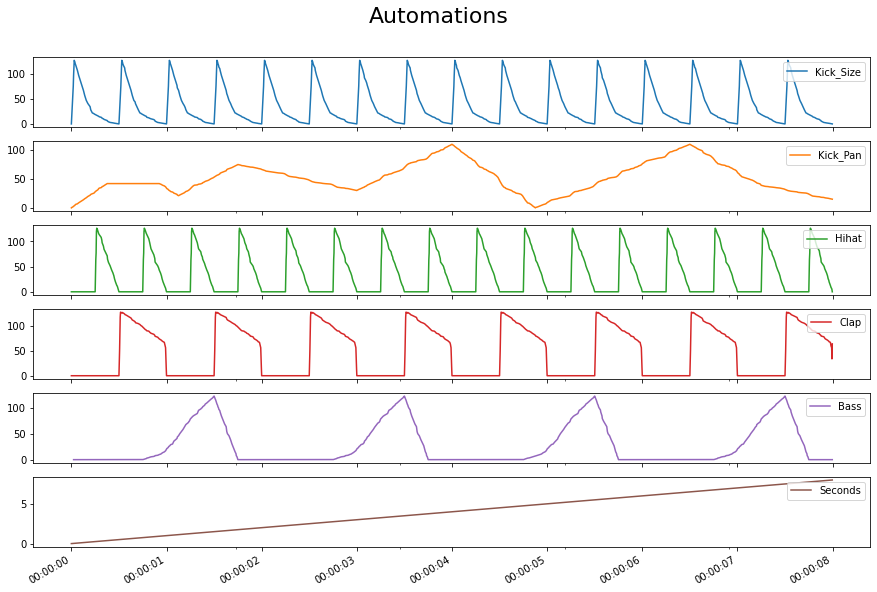

,Kick_Size,Kick_Pan,Hihat,Clap,Bass,Seconds
2022-05-09 00:00:00.000000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
2022-05-09 00:00:00.003333333,12.574184,0.583333,0.000000,0.000000,NaN,0.003333
2022-05-09 00:00:00.009999999,37.861584,1.166667,0.000000,0.000000,NaN,0.010000
2022-05-09 00:00:00.016666665,63.500000,1.750000,0.000000,0.000000,NaN,0.016667
2022-05-09 00:00:00.019999998,75.653389,2.333333,0.000000,0.000000,NaN,0.020000
...,...,...,...,...,...,...
2022-05-09 00:00:07.979999202,0.700198,15.653963,10.761905,63.011648,0.0,7.979999
2022-05-09 00:00:07.983332535,0.500000,15.490472,8.609524,59.451556,0.0,7.983333
2022-05-09 00:00:07.989999201,0.339286,15.326982,6.457143,55.891464,0.0,7.989999
2022-05-09 00:00:07.993332534,0.178571,15.163491,4.304762,33.534882,0.0,7.993333


In [11]:
total_duration = 8
detail = 10
time_index = pd.timedelta_range(0, 
                                periods=meta['fps'] * total_duration * detail, 
                                freq=str(round(meta['freq'],8)/detail)+'S')

time_d_float = time_index.total_seconds()
df = pd.DataFrame(index = time_d_float,columns = track_automations.keys())

for track in track_automations.keys():
    print(track)
    for t, v in track_automations[track].items():
        vv = float(v['value'])
        tt = float(t)
        if tt < 0:
            continue

        # print('key value - ',vv,tt)
        ix = df.index.get_loc(tt, method='nearest')
        # idx = df.index[df.index.get_loc(kk, method='nearest')]
        # print (ix)
        df[track].iloc[ix] = vv
df = df.astype(float).dropna(how='all')
df['Seconds'] = df.index
df.index = pd.Timestamp(datetime.date.today()) + pd.TimedeltaIndex(df.index, unit='s')
df = df.interpolate(method='linear', order = 2,axis=0)
plot_df(df)
df

In [33]:
resample_presicion = round(1/meta['fps'],9)
resample_presicion

0.033333333

In [34]:
df = df.resample(str(resample_presicion)+"S").mean()

In [35]:
df.shape

(240, 6)

In [36]:
df

,Kick_Size,Kick_Pan,Hihat,Clap,Bass,Seconds
2022-05-09 00:00:00.000000000,59.096294,1.750000,0.000000,0.000000,0.0,0.014762
2022-05-09 00:00:00.033333333,117.062166,5.687500,0.000000,0.000000,0.0,0.046667
2022-05-09 00:00:00.066666666,92.000000,9.625000,0.000000,0.000000,0.0,0.085000
2022-05-09 00:00:00.099999999,72.000000,13.125000,0.000000,0.000000,0.0,0.118333
2022-05-09 00:00:00.133333332,52.000000,16.625000,0.000000,0.000000,0.0,0.148333
...,...,...,...,...,...,...
2022-05-09 00:00:07.833333255,9.047636,19.185085,81.132746,83.789368,0.0,7.854444
2022-05-09 00:00:07.866666588,6.143194,18.455990,62.419048,79.727489,0.0,7.878333
2022-05-09 00:00:07.899999921,2.610357,17.627060,47.352381,75.609325,0.0,7.914999
2022-05-09 00:00:07.933333254,1.512905,16.575266,27.414839,69.801038,0.0,7.951999


In [38]:
df = df.reset_index().drop(columns = ['index','Seconds'])

In [39]:
df

,Kick_Size,Kick_Pan,Hihat,Clap,Bass
0,59.096294,1.750000,0.000000,0.000000,0.0
1,117.062166,5.687500,0.000000,0.000000,0.0
2,92.000000,9.625000,0.000000,0.000000,0.0
3,72.000000,13.125000,0.000000,0.000000,0.0
4,52.000000,16.625000,0.000000,0.000000,0.0
...,...,...,...,...,...
235,9.047636,19.185085,81.132746,83.789368,0.0
236,6.143194,18.455990,62.419048,79.727489,0.0
237,2.610357,17.627060,47.352381,75.609325,0.0
238,1.512905,16.575266,27.414839,69.801038,0.0


In [40]:
output_file = os.path.join(processing_folder, 'Test.csv')
output_file

'/Users/Alper/Documents/Processing/Sense/Test.csv'

In [41]:
df

,Kick_Size,Kick_Pan,Hihat,Clap,Bass
0,59.096294,1.750000,0.000000,0.000000,0.0
1,117.062166,5.687500,0.000000,0.000000,0.0
2,92.000000,9.625000,0.000000,0.000000,0.0
3,72.000000,13.125000,0.000000,0.000000,0.0
4,52.000000,16.625000,0.000000,0.000000,0.0
...,...,...,...,...,...
235,9.047636,19.185085,81.132746,83.789368,0.0
236,6.143194,18.455990,62.419048,79.727489,0.0
237,2.610357,17.627060,47.352381,75.609325,0.0
238,1.512905,16.575266,27.414839,69.801038,0.0


In [43]:
df.to_csv(output_file)

### Prapare DF for 30 FPS
- Resample
- Interpolate
- ForwardFill
- Fill 0

In [210]:
# resample_presicion = round(1/meta['fps'],9)
# print(resample_presicion)

# # resample to make it run with a specific FPS
# # interpolate again
# # front fill
# # fill 0

# # ‘krogh’, ‘piecewise_polynomial’, ‘spline’, ‘pchip’, ‘akima’, ‘cubicspline’

# df3 = df2.resample(str(0.01)+"S").mean()#.interpolate(method='spline', order = 4,axis=0).ffill().fillna(0)
# df3


In [157]:
# xx = df.iloc[:50]#.interpolate(method='linear', order = 2,axis=0)#.resample(str(0.01)+"S").mean().interpolate(method='linear', order = 2,axis=0)
# # xx#.iloc[:52]
# plot_df(xx)
# xx

In [211]:
# df = automations_dict_to_df(track_automations)

# # Retrieve metadata
# meta = calculator(bpm=120,fps=30)
# print(meta)

# # first interpolation 
# # front fill
# # fill 0
# df = df.interpolate(method='linear', order = 2,axis=0).ffill().fillna(0) 

# # set resample precision
# resample_presicion = round(1/meta['fps'],9)
# print(resample_presicion)

# # resample to make it run with a specific FPS
# # interpolate again
# # front fill
# # fill 0

# # ‘krogh’, ‘piecewise_polynomial’, ‘spline’, ‘pchip’, ‘akima’, ‘cubicspline’

# df = df.resample(str(0.01)+"S").mean()#.interpolate(method='spline', order = 4,axis=0).ffill().fillna(0)

# plot_df(df)

In [212]:
# resample_presicion = round(1/10,9)




# # msno.matrix(df2)
# plot_df(df2)